### Pronóstico de la vinculación laboral al mercado formal de recién graduados de pregrado en Colombia
### Autor: Deifilia Jiménez Silva
### Fecha: Diciembre de 2023

In [1]:
import pandas as pd
import os
import plotly.express as px
from matplotlib import pyplot
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from tabulate import tabulate
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split  #dividir los datos en entrenamiento y de test
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline #
from sklearn.preprocessing import OneHotEncoder  #para trabajar variable categoricas para ser consumidas por el algoritmo
from sklearn.impute import SimpleImputer  #imputar valores faltantes

###Metricas
from sklearn.model_selection import GridSearchCV  #para validación cruzada, analizar la estabilidad del algoritmo y obtener los mejores hiperparametros para realizar la predicción 
from sklearn import metrics  #para la evaluación
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error, mean_absolute_percentage_error

###Modelos
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor ## algoritmo a utilizar
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import ParameterGrid
from keras.callbacks import EarlyStopping
from keras.metrics import MeanSquaredError, MeanAbsoluteError
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler



## 1. CARGAR DATA

In [2]:
# Conjunto datos5
ruta_excel = 'C:/Users/deifi/Documents/Maestría Unir/Asignaturas/Trabajo fin de Master/DatosTFM/df_Conjunto5.xlsx'

# Carga el archivo Excel en un DataFrame de pandas
dataModelo = pd.read_excel(ruta_excel)

## 2. DESCRIPCIÓN DATASET

In [3]:
#cantidad de instancias(62435) y atributos(9)
print(dataModelo.shape)

(62435, 8)


In [4]:
#Visualización de los primeros instancias
print()
dataModelo.head()

,Region,Departamento,Sector,Acreditación,NivelFormación,CampoAmplio,Sexo,TasaCotizantes
0,Bogotá,11-Bogotá D.C.,Oficial,IES no acreditada,Tecnológico,Administración de Empresas y Derecho,Hombre,75.000000
1,Bogotá,11-Bogotá D.C.,Oficial,IES no acreditada,Tecnológico,Administración de Empresas y Derecho,Mujer,37.500000
2,Bogotá,11-Bogotá D.C.,Oficial,IES no acreditada,Universitario,Administración de Empresas y Derecho,Hombre,75.294118
3,Bogotá,11-Bogotá D.C.,Oficial,IES no acreditada,Universitario,Administración de Empresas y Derecho,Mujer,83.050847
4,Bogotá,11-Bogotá D.C.,Oficial,IES no acreditada,Universitario,Administración de Empresas y Derecho,Hombre,76.712329


In [5]:
#tipo de dato de cada variable, para saber cuales son categoricas y cuales númericas. 
#categóricas:Región, Departamento,Sector, Acreditación IES, Nivel Académico, Nivel Formación, Campo Amplio,Sexo
#numéricas:Tasa de cotizantes, añoseguimiento,añogrado
#no hay nulos tienen la misma cantidad de registros

dataModelo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62435 entries, 0 to 62434
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Region          62435 non-null  object 
 1   Departamento    62435 non-null  object 
 2   Sector          62435 non-null  object 
 3   Acreditación    62435 non-null  object 
 4   NivelFormación  62435 non-null  object 
 5   CampoAmplio     62435 non-null  object 
 6   Sexo            62435 non-null  object 
 7   TasaCotizantes  62435 non-null  float64
dtypes: float64(1), object(7)
memory usage: 3.8+ MB


### Variable Objetivo
La variable Tasa de cotizantes es la variable destino=target

>- PREDICCIÓN LA DE TASA DE VINCULACION DE ACUERDO Al SECTOR, ACREDITACION IES, NIVEL DE FORMACIÓN, CAMPO AMPLIO Y SEXO DE LA PERSONA


In [6]:
dataModelo.TasaCotizantes.describe()

count    62435.000000
mean        72.308625
std         22.074483
min          5.882353
25%         57.142857
50%         75.000000
75%         91.176471
max        100.000000
Name: TasaCotizantes, dtype: float64

In [7]:
## 9 VARIABLES PREDICTORAS 1 OBJETIVO
##Variable >Objetivo TasaCotizantes: Tasa de vinculaciónlaboral al mercado formal de la economía. 
##Variable continua por eso trabajaré Regresión

In [8]:
listado_variables=['TasaCotizantes','Region','Departamento','Sector','Acreditación','NivelFormación','CampoAmplio','Sexo']


In [9]:
dataModelo=dataModelo.reindex(columns=listado_variables)

In [10]:
dataModelo.head()

,TasaCotizantes,Region,Departamento,Sector,Acreditación,NivelFormación,CampoAmplio,Sexo
0,75.000000,Bogotá,11-Bogotá D.C.,Oficial,IES no acreditada,Tecnológico,Administración de Empresas y Derecho,Hombre
1,37.500000,Bogotá,11-Bogotá D.C.,Oficial,IES no acreditada,Tecnológico,Administración de Empresas y Derecho,Mujer
2,75.294118,Bogotá,11-Bogotá D.C.,Oficial,IES no acreditada,Universitario,Administración de Empresas y Derecho,Hombre
3,83.050847,Bogotá,11-Bogotá D.C.,Oficial,IES no acreditada,Universitario,Administración de Empresas y Derecho,Mujer
4,76.712329,Bogotá,11-Bogotá D.C.,Oficial,IES no acreditada,Universitario,Administración de Empresas y Derecho,Hombre


### Identificar tipo de datos predictores

In [11]:
dataModelo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62435 entries, 0 to 62434
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TasaCotizantes  62435 non-null  float64
 1   Region          62435 non-null  object 
 2   Departamento    62435 non-null  object 
 3   Sector          62435 non-null  object 
 4   Acreditación    62435 non-null  object 
 5   NivelFormación  62435 non-null  object 
 6   CampoAmplio     62435 non-null  object 
 7   Sexo            62435 non-null  object 
dtypes: float64(1), object(7)
memory usage: 3.8+ MB


## Preprocesamiento de datos Columns Transformer de sckit-learn

In [12]:
categorical_features = ['Region','Departamento','Sector','Acreditación','NivelFormación','CampoAmplio','Sexo']

numeric_features = []

In [13]:
y=dataModelo.loc[:,'TasaCotizantes']# variable objetivo
X = dataModelo.iloc[:, 1:]#predictores

In [14]:
#print(X)

In [15]:
#print (y)

In [16]:
# Crear transformadores para variables categóricas y numéricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='sinInformacion')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))  # Puedes cambiar 'mean' por otra estrategia de imputación
])


In [17]:
# Crear un preprocesador que aplique transformadores según el tipo de variable
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

## División del dataset en datos de entrenamiento y datos de test 

In [18]:
# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba 70:30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#stratify=y garantiza que la proporción de clases en y_train e y_test sea similar a la proporción en y. Esto es crucial cuando hay desbalance en las clases
##no se puede utilizar porque la case objeto hay programas con un dato

In [19]:
print('Cantidad de datos entrenamiento: ',X_train.shape,y_train.shape)
print('Cantidad de datos pruebas: ', X_test.shape, y_test.shape )

Cantidad de datos entrenamiento:  (43704, 7) (43704,)
Cantidad de datos pruebas:  (18731, 7) (18731,)


# 1. Aplicación de k-NN Regresión con Scikit-Learn

SIN APLICAR PESOS

In [20]:
# Crear el modelo k-NN Regresión
knn_regressor = KNeighborsRegressor(n_neighbors=10)  # Puedes ajustar el número de vecinos según tu preferencia

# Crear el pipeline que incluye el preprocesador y el modelo
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', knn_regressor)])

In [21]:
## si aumento el n_neiggbors disminuye el rendimiento

In [22]:
# Entrenar el modelo
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)


La tasa de error de un modelo predictivo puede evaluarse aplicando varias métricas derivadas de funciones de perdida en ML y en estadística. El concepto básico de la evaluación de la precisión en el análisis de regresión consiste en comparar la variable objetivo con la predicha

In [23]:
# Evaluar el rendimiento del modelo 

## El RMSE se interpreta como el error típico de las predicciones del modelo

rfr_r2 = r2_score(y_test, y_pred)
print('coeficiente de determinación (R^2):', rfr_r2)

rfr_RSME=metrics.mean_squared_error(y_test,y_pred, squared=False)
print('La raiz del Error Cuadratico Medio (RMSE) es :',rfr_RSME)


# MAE (error absoluto medio)
mae = mean_absolute_error(y_test, y_pred)
print('error absoluto medio MAE:', mae)

# MAPE (porcentaje absoluto medio del error)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('porcentaje absoluto medio del error MAPE:', mape)

coeficiente de determinación (R^2): 0.17000615846155465
La raiz del Error Cuadratico Medio (RMSE) es : 20.002005286654338
error absoluto medio MAE: 15.80519512521204
porcentaje absoluto medio del error MAPE: 29.89228030788001


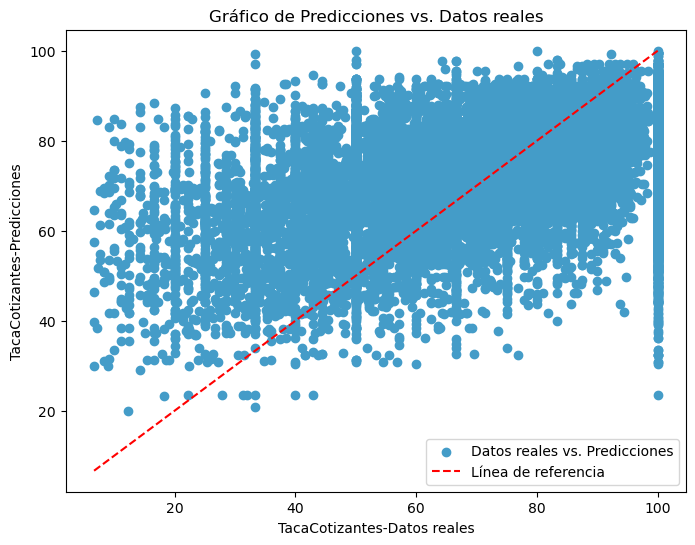

In [24]:
# Graficar el RMSE
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='#449CC8', label='Datos reales vs. Predicciones')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', label='Línea de referencia')
plt.title('Gráfico de Predicciones vs. Datos reales')
plt.xlabel('TacaCotizantes-Datos reales')
plt.ylabel('TacaCotizantes-Predicciones')
plt.legend()
plt.show()

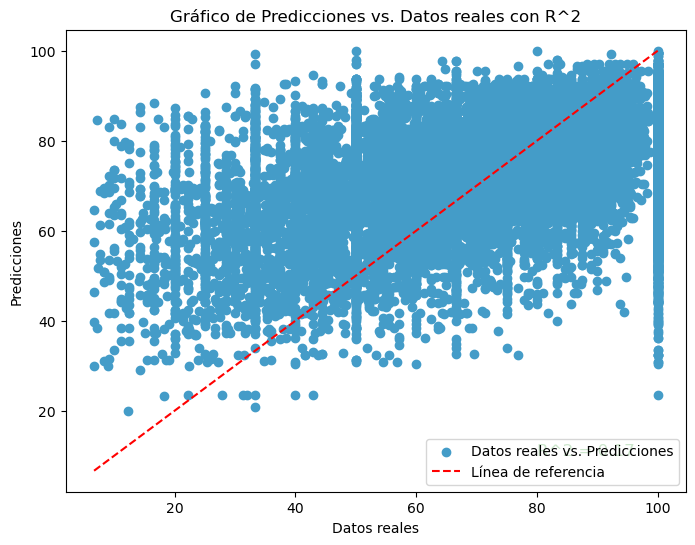

In [25]:
# Graficar el R^2
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='#449CC8', label='Datos reales vs. Predicciones')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', label='Línea de referencia')
plt.title('Gráfico de Predicciones vs. Datos reales con R^2')
plt.xlabel('Datos reales')
plt.ylabel('Predicciones')
plt.legend()

# Agregar texto con el valor de R^2
plt.text(0.8 * max(y_test), 0.1 * max(y_test), f'R^2 = {rfr_r2:.2f}', fontsize=12, color='green')

plt.show()

In [26]:
comparacion=pd.DataFrame(np.c_[y_test, y_pred],columns=['Test','Predict'])
display(comparacion)

,Test,Predict
0,93.750000,69.568326
1,100.000000,86.237407
2,91.666667,94.118292
3,80.000000,64.001732
4,66.666667,65.806985
...,...,...
18726,100.000000,83.032206
18727,66.666667,79.655526
18728,50.000000,65.694051
18729,75.000000,87.449681


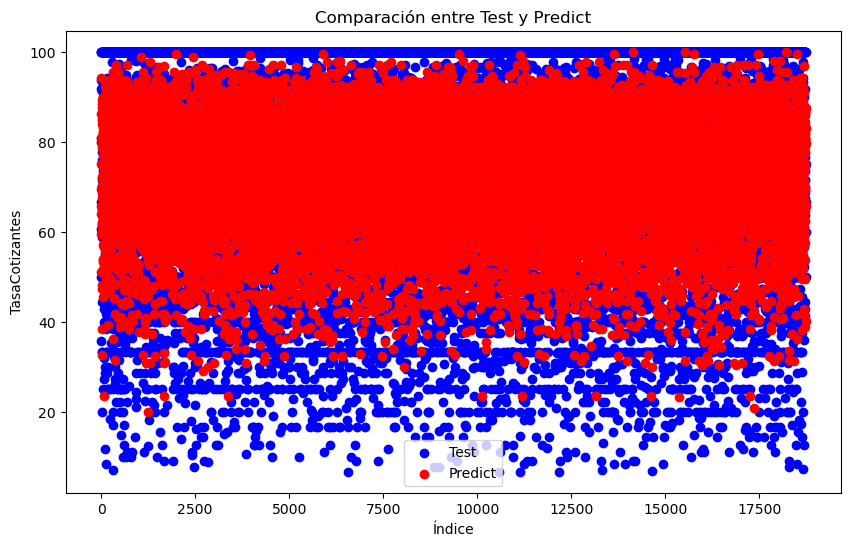

In [27]:
# Graficar la comparación
plt.figure(figsize=(10, 6))
plt.scatter(comparacion.index, comparacion['Test'], color='blue', label='Test')
plt.scatter(comparacion.index, comparacion['Predict'], color='red', label='Predict')
plt.xlabel('Índice')
plt.ylabel('TasaCotizantes')
plt.title('Comparación entre Test y Predict')
plt.legend()
plt.show()

Conclusión: Los resultados indican que la aplicación de pesos a las muestras no mejoró el rendimiento del modelo y, de hecho, empeoró significativamente. Un coeficiente de determinación (R^2) negativo y un RMSE elevado sugieren que el modelo no está capturando adecuadamente la variabilidad en los datos de prueba.
Coeficiente de determinación (R^2): -10.815751313948
Raíz del Error Cuadrático Medio (RMSE): 75.59995515443998

# 2. Regresión Lineal

In [28]:
# Crear el modelo de Regresión Lineal
regression_model = LinearRegression()

In [29]:
# Crear el pipeline con preprocesamiento y el modelo
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', regression_model)])

In [30]:
# Entrenar el modelo
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  []),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='sinInformacion',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Region', 'Departamento',
                                                   'Sector', 'Acreditación',


In [31]:
# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)


In [32]:
# Evaluar el rendimiento del modelo
## El RMSE se interpreta como el error típico de las predicciones del modelo

rfr_r2 = r2_score(y_test, y_pred)
print('coeficiente de determinación (R^2):', rfr_r2)

rfr_RSME=metrics.mean_squared_error(y_test,y_pred, squared=False)
print('La raiz del Error Cuadratico Medio (RMSE) es :',rfr_RSME)


# MAE (error absoluto medio)
mae = mean_absolute_error(y_test, y_pred)
print('error absoluto medio MAE:', mae)

# MAPE (porcentaje absoluto medio del error)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('porcentaje absoluto medio del error MAPE:', mape)

coeficiente de determinación (R^2): 0.17549556097896468
La raiz del Error Cuadratico Medio (RMSE) es : 19.9357510553479
error absoluto medio MAE: 16.0139648403357
porcentaje absoluto medio del error MAPE: 30.693419250017044


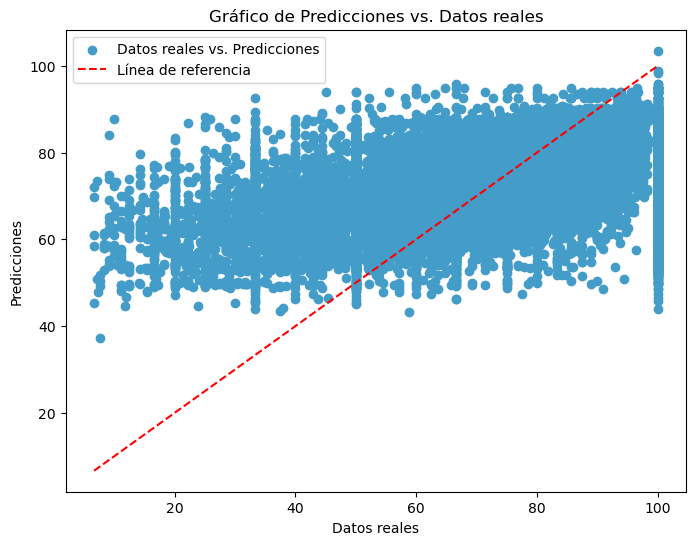

In [33]:
# Graficar el RMSE
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='#449CC8', label='Datos reales vs. Predicciones')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', label='Línea de referencia')
plt.title('Gráfico de Predicciones vs. Datos reales')
plt.xlabel('Datos reales')
plt.ylabel('Predicciones')
plt.legend()
plt.show()

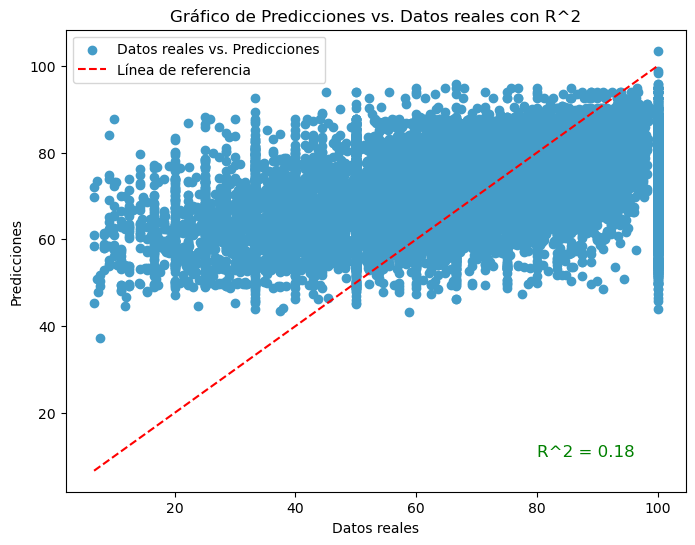

In [34]:
# Graficar el R^2
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='#449CC8', label='Datos reales vs. Predicciones')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', label='Línea de referencia')
plt.title('Gráfico de Predicciones vs. Datos reales con R^2')
plt.xlabel('Datos reales')
plt.ylabel('Predicciones')
plt.legend()

# Agregar texto con el valor de R^2
plt.text(0.8 * max(y_test), 0.1 * max(y_test), f'R^2 = {rfr_r2:.2f}', fontsize=12, color='green')

plt.show()

In [35]:
comparacion=pd.DataFrame(np.c_[y_test, y_pred],columns=['Test','Predict'])
display(comparacion)

,Test,Predict
0,93.750000,77.893470
1,100.000000,85.446895
2,91.666667,83.933867
3,80.000000,78.165596
4,66.666667,63.140238
...,...,...
18726,100.000000,70.339292
18727,66.666667,81.835589
18728,50.000000,64.374035
18729,75.000000,83.676257


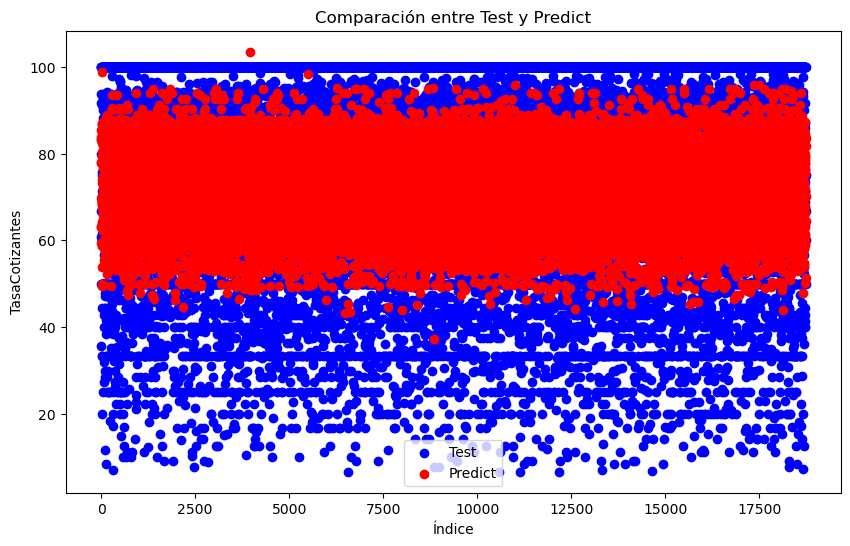

In [36]:
# Graficar la comparación
plt.figure(figsize=(10, 6))
plt.scatter(comparacion.index, comparacion['Test'], color='blue', label='Test')
plt.scatter(comparacion.index, comparacion['Predict'], color='red', label='Predict')
plt.xlabel('Índice')
plt.ylabel('TasaCotizantes')
plt.title('Comparación entre Test y Predict')
plt.legend()
plt.show()

# 3. Random Forest Regressor

In [37]:
# Crear el modelo Random Forest Regressor
model = RandomForestRegressor(n_estimators=300,
                              criterion='squared_error',
                              max_depth=16,
                              max_features='sqrt',
                              random_state=42)

In [38]:
# Crear el pipeline con el preprocesador y el modelo
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

In [39]:
# Entrenar el modelo
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  []),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='sinInformacion',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Region', 'Departamento',
                                                   'Sector', 'Acreditación',


In [40]:
# Hacer predicciones en el conjunto de prueba
y_pred = pipeline.predict(X_test)

In [41]:
# Evaluar el rendimiento del modelo 

## El RMSE se interpreta como el error típico de las predicciones del modelo

rfr_r2 = r2_score(y_test, y_pred)
print('coeficiente de determinación (R^2):', rfr_r2)

rfr_RSME=metrics.mean_squared_error(y_test,y_pred, squared=False)
print('La raiz del Error Cuadratico Medio (RMSE) es :',rfr_RSME)


# MAE (error absoluto medio)
mae = mean_absolute_error(y_test, y_pred)
print('error absoluto medio MAE:', mae)

# MAPE (porcentaje absoluto medio del error)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('porcentaje absoluto medio del error MAPE:', mape)

coeficiente de determinación (R^2): 0.22999324645152064
La raiz del Error Cuadratico Medio (RMSE) es : 19.265636856390383
error absoluto medio MAE: 15.351206056686232
porcentaje absoluto medio del error MAPE: 29.12827209896896


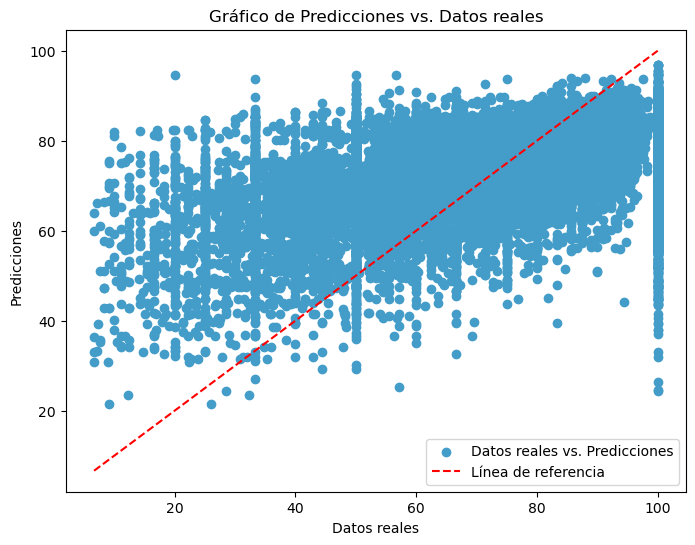

In [42]:
# Graficar el RMSE
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='#449CC8', label='Datos reales vs. Predicciones')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', label='Línea de referencia')
plt.title('Gráfico de Predicciones vs. Datos reales')
plt.xlabel('Datos reales')
plt.ylabel('Predicciones')
plt.legend()
plt.show()

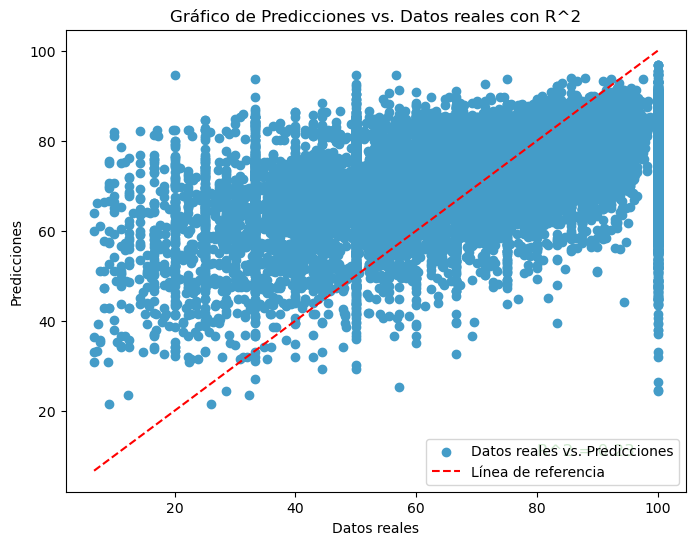

In [43]:
 #Graficar el R^2
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='#449CC8', label='Datos reales vs. Predicciones')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', label='Línea de referencia')
plt.title('Gráfico de Predicciones vs. Datos reales con R^2')
plt.xlabel('Datos reales')
plt.ylabel('Predicciones')
plt.legend()

# Agregar texto con el valor de R^2
plt.text(0.8 * max(y_test), 0.1 * max(y_test), f'R^2 = {rfr_r2:.2f}', fontsize=12, color='green')

plt.show()

In [44]:
comparacion=pd.DataFrame(np.c_[y_test, y_pred],columns=['Test','Predict'])
display(comparacion)

,Test,Predict
0,93.750000,78.454089
1,100.000000,80.725019
2,91.666667,92.785692
3,80.000000,73.590511
4,66.666667,59.338822
...,...,...
18726,100.000000,74.128244
18727,66.666667,82.113838
18728,50.000000,65.017971
18729,75.000000,85.026417


Test es el valor real(color azul) y el predic(color rojo) hace referencia a la predicción, en unos casos esta muy cercana mientras que otros está muy lejana

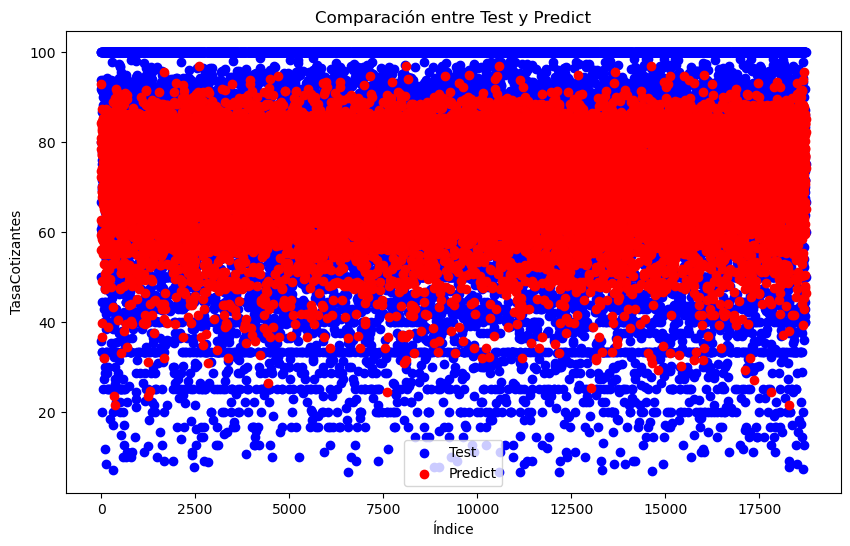

In [45]:
# Graficar la comparación
plt.figure(figsize=(10, 6))
plt.scatter(comparacion.index, comparacion['Test'], color='blue', label='Test')
plt.scatter(comparacion.index, comparacion['Predict'], color='red', label='Predict')
plt.xlabel('Índice')
plt.ylabel('TasaCotizantes')
plt.title('Comparación entre Test y Predict')
plt.legend()
plt.show()

# 4. Gradient Boosting Regressor

In [46]:
# Construir el modelo Gradient Boosting Regressor
model = GradientBoostingRegressor(n_estimators=300, learning_rate=0.1, max_depth=3, random_state=42)

In [47]:
# Crear el pipeline que incluye el preprocesamiento y el modelo
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])


In [48]:
# Ajustar el modelo
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  []),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='sinInformacion',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Region', 'Departamento',
                                                   'Sector', 'Acreditación',


In [49]:
# Realizar predicciones en el conjunto de prueba
y_pred = pipeline.predict(X_test)

In [50]:
# Evaluar el rendimiento del modelo
rfr_r2 = r2_score(y_test, y_pred)
print('coeficiente de determinación (R^2):', rfr_r2)

rfr_RSME=metrics.mean_squared_error(y_test,y_pred, squared=False)
print('La raiz del Error Cuadratico Medio (RMSE) es :',rfr_RSME)


# MAE (error absoluto medio)
mae = mean_absolute_error(y_test, y_pred)
print('error absoluto medio MAE:', mae)

# MAPE (porcentaje absoluto medio del error)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('porcentaje absoluto medio del error MAPE:', mape)

coeficiente de determinación (R^2): 0.21790637440935057
La raiz del Error Cuadratico Medio (RMSE) es : 19.416255391400835
error absoluto medio MAE: 15.513312787080789
porcentaje absoluto medio del error MAPE: 29.528103956558905


Mejora un poco con n_estimators=300


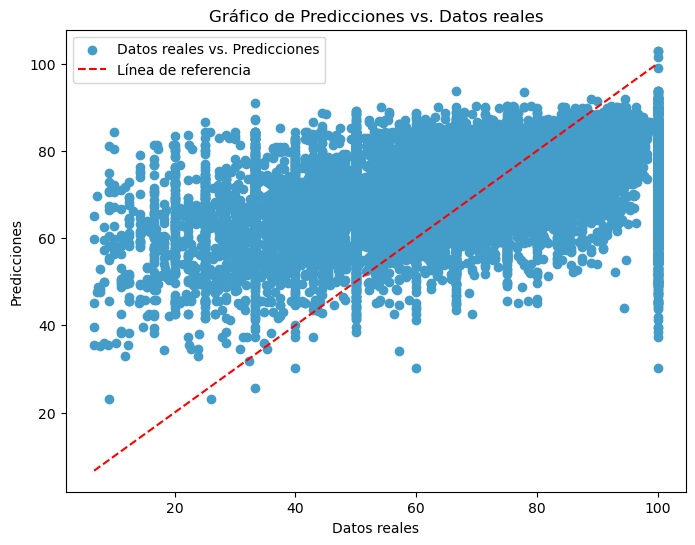

In [51]:
# Graficar el RMSE
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='#449CC8', label='Datos reales vs. Predicciones')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', label='Línea de referencia')
plt.title('Gráfico de Predicciones vs. Datos reales')
plt.xlabel('Datos reales')
plt.ylabel('Predicciones')
plt.legend()
plt.show()

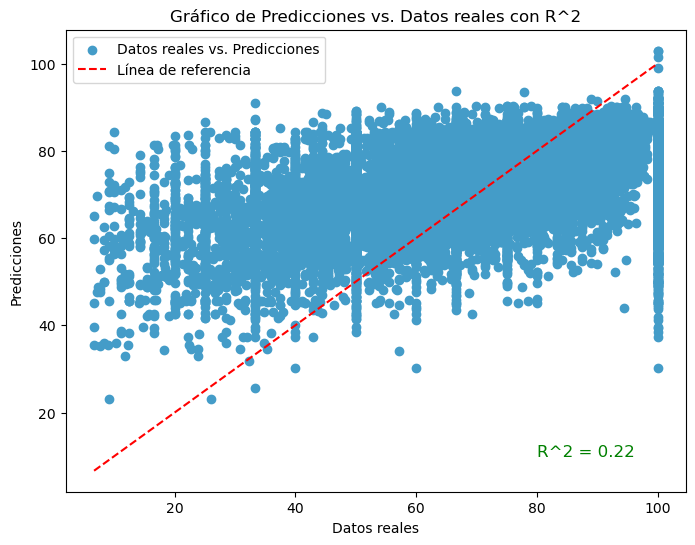

In [52]:
 #Graficar el R^2
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='#449CC8', label='Datos reales vs. Predicciones')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', label='Línea de referencia')
plt.title('Gráfico de Predicciones vs. Datos reales con R^2')
plt.xlabel('Datos reales')
plt.ylabel('Predicciones')
plt.legend()

# Agregar texto con el valor de R^2
plt.text(0.8 * max(y_test), 0.1 * max(y_test), f'R^2 = {rfr_r2:.2f}', fontsize=12, color='green')

plt.show()

In [53]:
comparacion=pd.DataFrame(np.c_[y_test, y_pred],columns=['Test','Predict'])
display(comparacion)

,Test,Predict
0,93.750000,79.045531
1,100.000000,82.336431
2,91.666667,84.156656
3,80.000000,73.506102
4,66.666667,62.514291
...,...,...
18726,100.000000,72.562836
18727,66.666667,82.839941
18728,50.000000,67.251273
18729,75.000000,87.045273


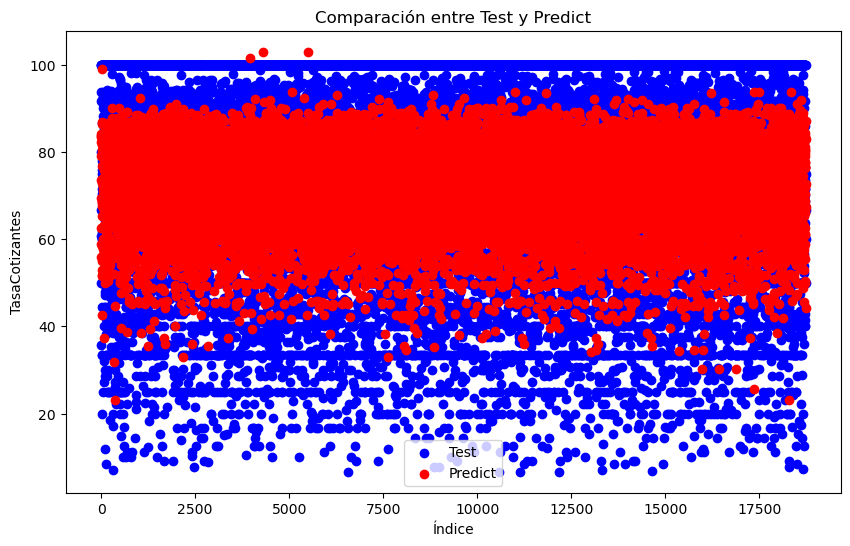

In [54]:
# Graficar la comparación
plt.figure(figsize=(10, 6))
plt.scatter(comparacion.index, comparacion['Test'], color='blue', label='Test')
plt.scatter(comparacion.index, comparacion['Predict'], color='red', label='Predict')
plt.xlabel('Índice')
plt.ylabel('TasaCotizantes')
plt.title('Comparación entre Test y Predict')
plt.legend()
plt.show()

## 5. Support Vector Regressor (SVR)

In [55]:
# Inicializar el modelo SVR
model = SVR(kernel='rbf')

In [56]:
# Crear el pipeline con el preprocesador y el modelo
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

In [57]:
# Entrenar el modelo
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  []),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='sinInformacion',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Region', 'Departamento',
                                                   'Sector', 'Acreditación',


In [58]:
# Realizar predicciones en el conjunto de prueba
y_pred = pipeline.predict(X_test)

coeficiente de determinación (R^2): 0.21194112383481334
La raiz del Error Cuadratico Medio (RMSE) es : 19.490161385320597
error absoluto medio MAE: 15.323121004747373
porcentaje absoluto medio del error MAPE: 29.168742540546944


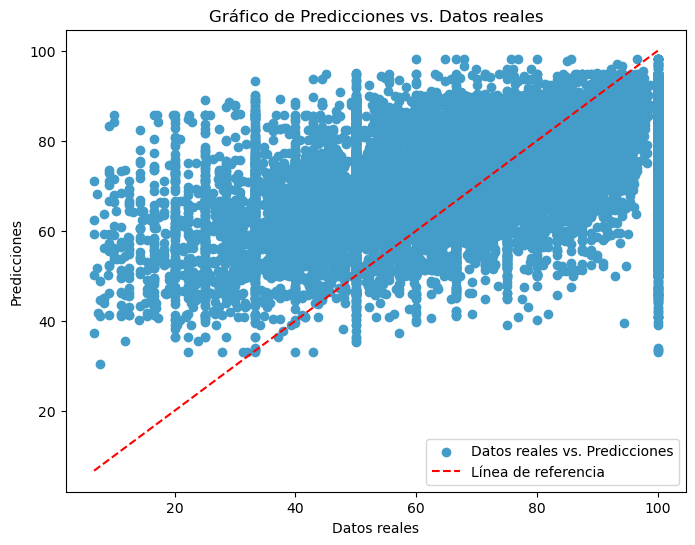

In [59]:
# Evaluar el rendimiento del modelo
rfr_r2 = r2_score(y_test, y_pred)
print('coeficiente de determinación (R^2):', rfr_r2)

rfr_RSME=metrics.mean_squared_error(y_test,y_pred, squared=False)
print('La raiz del Error Cuadratico Medio (RMSE) es :',rfr_RSME)


# MAE (error absoluto medio)
mae = mean_absolute_error(y_test, y_pred)
print('error absoluto medio MAE:', mae)

# MAPE (porcentaje absoluto medio del error)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('porcentaje absoluto medio del error MAPE:', mape)

# Graficar el RMSE
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='#449CC8', label='Datos reales vs. Predicciones')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', label='Línea de referencia')
plt.title('Gráfico de Predicciones vs. Datos reales')
plt.xlabel('Datos reales')
plt.ylabel('Predicciones')
plt.legend()
plt.show()


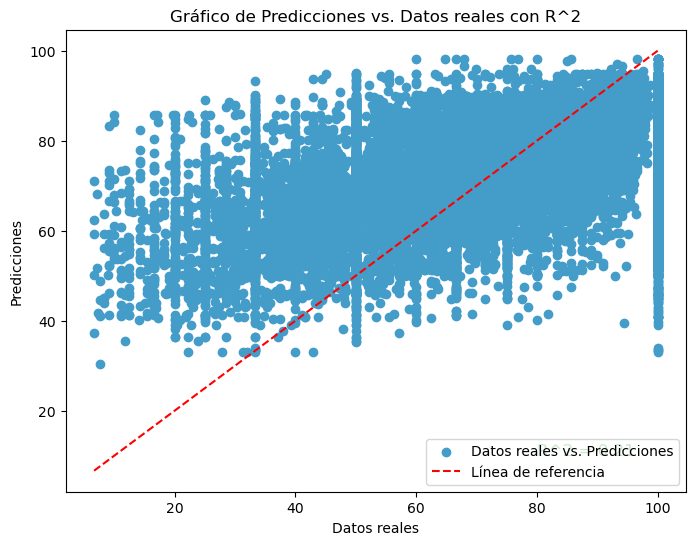

In [60]:
 #Graficar el R^2
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='#449CC8', label='Datos reales vs. Predicciones')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', label='Línea de referencia')
plt.title('Gráfico de Predicciones vs. Datos reales con R^2')
plt.xlabel('Datos reales')
plt.ylabel('Predicciones')
plt.legend()

# Agregar texto con el valor de R^2
plt.text(0.8 * max(y_test), 0.1 * max(y_test), f'R^2 = {rfr_r2:.2f}', fontsize=12, color='green')

plt.show()

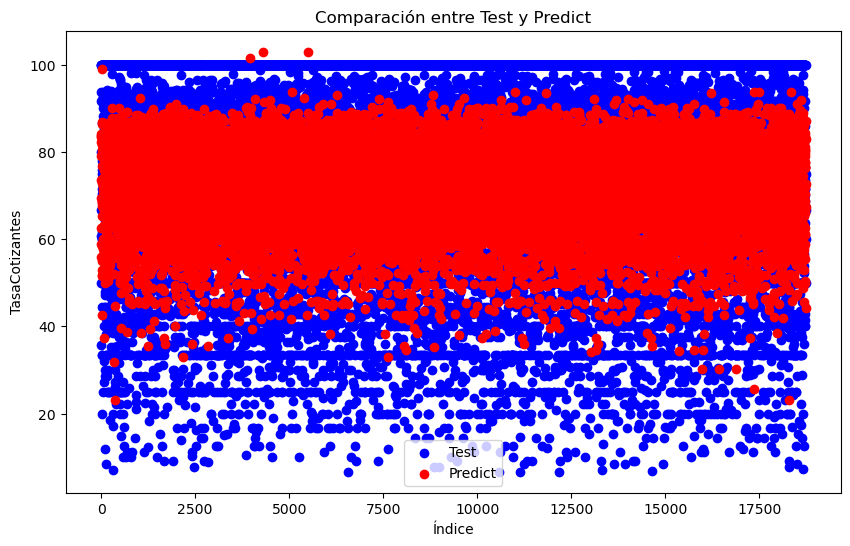

In [61]:
# Graficar la comparación
plt.figure(figsize=(10, 6))
plt.scatter(comparacion.index, comparacion['Test'], color='blue', label='Test')
plt.scatter(comparacion.index, comparacion['Predict'], color='red', label='Predict')
plt.xlabel('Índice')
plt.ylabel('TasaCotizantes')
plt.title('Comparación entre Test y Predict')
plt.legend()
plt.show()

# 6 Red Neuronal (Neural Network)

In [62]:
# Define la métrica de R² personalizada
def r2_metric(y_true, y_pred):
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - SS_res / (SS_tot + tf.keras.backend.epsilon())

# Registrar la métrica en el ámbito de objetos personalizados de Keras
tf.keras.utils.get_custom_objects()['r2_score'] = r2_metric

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Combina los conjuntos de entrenamiento y prueba antes de la transformación
X_combined = pd.concat([X_train, X_test])

# Definir columnas que necesitan ser codificadas
categorical_cols = ['Region','Departamento','Sector','Acreditación','NivelFormación','CampoAmplio','Sexo']
numeric_cols = []  # Asegúrate de incluir la columna objetivo si es numérica

# Crear transformadores para variables categóricas y numéricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='sinInformacion')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Crear un transformador para aplicar codificación a columnas categóricas y normalización a columnas numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Aplicar transformaciones al conjunto combinado
X_combined_preprocessed = preprocessor.fit_transform(X_combined)

# Separar de nuevo en conjuntos de entrenamiento y prueba
X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Convertir las matrices dispersas a densas
X_train_preprocessed_dense = X_train_preprocessed.toarray()
X_test_preprocessed_dense = X_test_preprocessed.toarray()

# Convertir los datos a tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_preprocessed_dense, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_preprocessed_dense, y_test))

# Asegúrate de mezclar y repetir los datos (opcional, dependiendo de tus necesidades)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32).repeat()
test_dataset = test_dataset.batch(32)

# Inicializar el modelo de Red Neuronal
architecture = 128
model = Sequential()
model.add(Dense(architecture, activation='relu', input_dim=X_train_preprocessed_dense.shape[1]))
model.add(Dense(architecture, activation='relu'))  # Capa oculta adicional
model.add(Dense(1))  # Capa de salida para regresión

# Compilar el modelo con R^2 como métrica adicional
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[MeanSquaredError(), MeanAbsoluteError(), 'mape', 'r2_score'])

# Callback para detener el entrenamiento temprano si no hay mejoras
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Dividir manualmente el conjunto de entrenamiento para tener un conjunto de validación
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_preprocessed_dense, y_train, test_size=0.3, random_state=42)

# Entrenar el modelo con callback de EarlyStopping
history = model.fit(
    train_dataset,
    epochs=50,
    steps_per_epoch=X_train_preprocessed_dense.shape[0] // 32,
    validation_data=test_dataset,
    validation_steps=len(X_test_preprocessed_dense) // 32,
    callbacks=[early_stopping]
)

Epoch 1/50
1560/1560 [==============================] - 5s 2ms/step - loss: 567.8052 - mean_squared_error: 567.8052 - mean_absolute_error: 18.1819 - mape: 33.7117 - r2_score: -0.2231 - val_loss: 387.5154 - val_mean_squared_error: 387.5154 - val_mean_absolute_error: 15.8106 - val_mape: 30.3320 - val_r2_score: 0.1512
Epoch 2/50
1560/1560 [==============================] - 4s 2ms/step - loss: 399.1216 - mean_squared_error: 399.1216 - mean_absolute_error: 16.0143 - mape: 30.7247 - r2_score: 0.1514 - val_loss: 376.9840 - val_mean_squared_error: 376.9840 - val_mean_absolute_error: 15.5044 - val_mape: 29.5683 - val_r2_score: 0.1723
Epoch 3/50
1560/1560 [==============================] - 4s 3ms/step - loss: 392.0109 - mean_squared_error: 392.0109 - mean_absolute_error: 15.8412 - mape: 30.2530 - r2_score: 0.1632 - val_loss: 373.9569 - val_mean_squared_error: 373.9569 - val_mean_absolute_error: 15.3937 - val_mape: 29.2213 - val_r2_score: 0.1779
Epoch 4/50
1560/1560 [=============================

In [ ]:
# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test_preprocessed_dense).flatten()

In [ ]:
# Evaluar el rendimiento del modelo
#loss = model.evaluate(X_test_preprocessed_dense, y_test, verbose=0)
loss, mse, mae, mape, r2_score = model.evaluate(X_val_split, y_val_split)
#mse = mean_squared_error(y_test, y_pred)
#mae = mean_absolute_error(y_test, y_pred)
#r2 = r2_score(y_test, y_pred)
#mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'R² Score: {r2_score}')
print(f'Loss: {loss}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')

# Visualizar curvas de pérdida
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Elección de Hiperparámetos para redes

In [ ]:


# Función auxiliar para crear el modelo
def create_model(architecture=32, optimizer='adam'):
    model = Sequential()
    for _ in range(architecture):
        model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Datos de entrenamiento y prueba 
X_train = np.random.rand(100, 10)
y_train = np.random.rand(100)
X_test = np.random.rand(20, 10)
y_test = np.random.rand(20)

# Definir la cuadrícula de hiperparámetros para la búsqueda
param_grid = {
    'architecture': [32, 64, 128],
    'optimizer': ['adam', 'sgd']
}

best_params = None
best_model = None
best_score = np.inf  # Inicializar con un valor grande

# Búsqueda de hiperparámetros
for params in ParameterGrid(param_grid):
    model = create_model(**params)
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    if mse < best_score:
        best_score = mse
        best_params = params
        best_model = model

# Imprimir los mejores hiperparámetros encontrados
print("Mejores Hiperparámetros:", best_params)

# Evaluar el rendimiento del modelo con los mejores hiperparámetros
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'R^2 Score: {r2}')